Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu, \alpha) = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot p_c\left(x|\alpha\right)$$

where $c$ stands for the various physics channels that contribute to the final state $x$, $\mu$ is the signal-strength parameter and $\alpha$ is the vector of nuisance parameters associated with the various systematic uncertainties in the model. Note that we are assuming that the parameter $\mu$-dependence is known analytically and that we have simulation models for each of the channels $p_c(x)$. 

The objective is to build the test statistic for composite hypothesis testing:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})}{p(x|\hat{\mu}, \hat{\alpha})}$$

A direct approach would then be to model the probability density $p(x|\mu, \alpha)$ using NNs. But that is a more difficult task than training probability density ratios. We use a simple trick:

$$t_\mu = -2 \ln \frac{p(x|\mu, \hat{\hat{\alpha}})/p_{ref}(x)}{p(x|\hat{\mu}, \hat{\alpha})/p_{ref}(x)}$$

to turn this into a density ratio estimation problem:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\nu(\mu, \alpha)} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot \frac{p_c\left(x|\alpha\right)}{p_{ref}(x)}$$

Factorizing out the $\alpha$-dependence in the density ratios:

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot \nu_c(\alpha) \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

Furthermore, instead of training NNs parameterized on $\mu$ and $\alpha$, we use analytical parameterizations to simplify the problem to training only parameter-independent density ratios.

Let's set this up for the ttbar dataset!

In [1]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-02-12 19:31:59.709370: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-12 19:32:00.344291: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
weights = np.load(f"{saved_data}weights.npy")

In [3]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [4]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [5]:
# Build a pandas dataframe from the arrays for density ratio training and validation
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']
dataset_incl = pd.DataFrame(training_features, columns=columns)

# Some scaling to reduce the spread of pt distributions 
dataset_incl['log_lepton_pt'] = np.log(dataset_incl['lepton_pt'].ravel())
dataset_incl['log_H_T'] = np.log(dataset_incl['H_T'].ravel()+1.0) # Add the one to compensate to avoid log of 0

# Some scaling to reduce the spread of pt distributions 
dataset_incl['train_labels_presel'] = train_labels
dataset_incl['type'] = type_vec
dataset_incl['weights'] = weights

In [6]:
# Normalizing the training weights - only discriminating shapes, not norms

weights_normed = weights.copy()

for key in labels_dict:

    weights_normed[train_labels==labels_dict[key]] /= weights[train_labels==labels_dict[key]].sum()

dataset_incl['weights_normed'] = weights_normed


The density ratios need to be trained on phase space regions with support for the reference hypothesis $p_{ref}(x) > 0$.

To ensure this, we make a selection that selects events in the phase space regions with $p_{ref}(x) > 0$, and only perform the NSBI fit in this selected analysis region. A natural choice for the reference hypothesis is then a mix of signal hypotheses $p_{ref}(x) = \frac{1}{\sum_S \nu_S} \sum_S \frac{d\sigma_S}{dx}$.

A multi-class classification NN, with softmax output, is trained to output a score:

$$ \text{NN}_\text{presel} = \log \left[\frac{\sum_S P_S (x)}{\sum_B P_B(x)} \right]$$

where $P_X$ are the probability scores outputted from the softmax layer of the trained NN.



Training the Preselection NN
===

In [7]:
# Only use lepton kinematics
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['lepton_pt', 'lepton_eta', 'lepton_phi']

# Only use lepton kinematics - use log pT for reduced spread
columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi']

# Use lepton kinematics and the sum of jet pT observable 
columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi'] # Subset of features which need scaling

In [11]:
USE_SAVED_MODEL_PRESEL=False

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluatePreselNN

preselectionTraining = TrainEvaluatePreselNN(dataset_incl, columns, columns_scaling)

In [12]:
path_to_saved_presel_model = './preselection_saved_NN/'

if not USE_SAVED_MODEL_PRESEL:
    preselectionTraining.train(test_size=0.15, random_state=42, path_to_save=path_to_saved_presel_model)

else:
    preselectionTraining.get_trained_model(path_to_saved_presel_model)

2025-02-12 19:34:27.145249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3234 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:81:00.0, compute capability: 8.0


Epoch 1/20


2025-02-12 19:34:28.140300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-02-12 19:34:28.170499: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb8ccf618e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-12 19:34:28.170580: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.5gb, Compute Capability 8.0
2025-02-12 19:34:28.177200: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-12 19:34:28.190934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2025-02-12 19:34:28.246649: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-12 19:34

2935/2935 [==============================] - 9s 2ms/step - loss: 6.2678e-07 - accuracy: 0.6912 - val_loss: 5.4714e-07 - val_accuracy: 0.7234
Epoch 2/20
2935/2935 [==============================] - 7s 2ms/step - loss: 5.4687e-07 - accuracy: 0.7216 - val_loss: 5.4388e-07 - val_accuracy: 0.7235
Epoch 3/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.4432e-07 - accuracy: 0.7220 - val_loss: 5.4182e-07 - val_accuracy: 0.7239
Epoch 4/20
2935/2935 [==============================] - 6s 2ms/step - loss: 5.4227e-07 - accuracy: 0.7222 - val_loss: 5.3997e-07 - val_accuracy: 0.7242
Epoch 5/20
2935/2935 [==============================] - 7s 2ms/step - loss: 5.4033e-07 - accuracy: 0.7225 - val_loss: 5.3819e-07 - val_accuracy: 0.7243
Epoch 6/20
2935/2935 [==============================] - 7s 2ms/step - loss: 5.3852e-07 - accuracy: 0.7227 - val_loss: 5.3657e-07 - val_accuracy: 0.7244
Epoch 7/20
2935/2935 [==============================] - 8s 3ms/step - loss: 5.3695e-07 - accuracy: 

In [13]:
# Get predictions (softmax outputs)
pred_NN = preselectionTraining.predict(dataset_incl)

110475/110475 [==============================] - 75s 682us/step


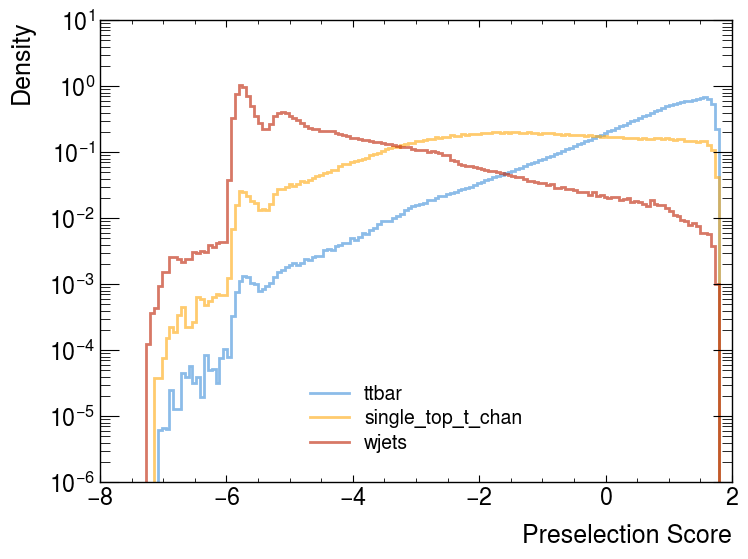

In [21]:
# the preselection score as defined above - log(P_S/P_B)
presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(pred_NN[:, labels_dict["single_top_t_chan"]] + pred_NN[:, labels_dict["wjets"]]))

min_pred = np.amin(presel_score)
max_pred = np.amax(presel_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}
for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(presel_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

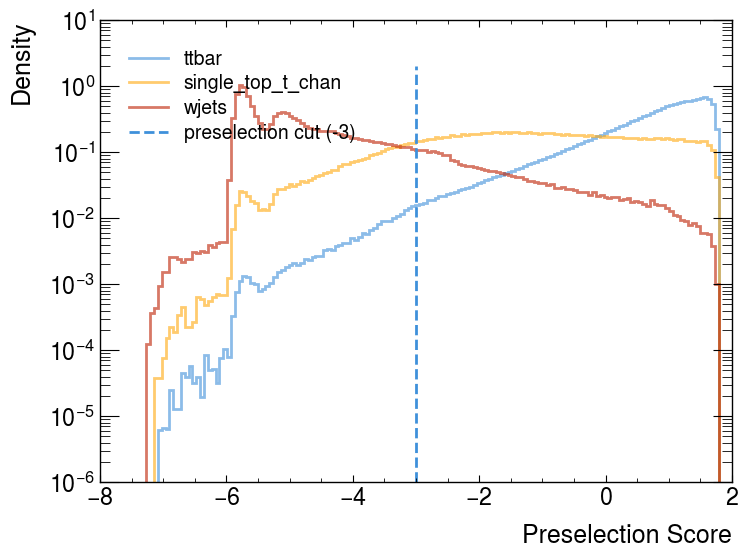

In [22]:
preselection_cut = -3

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [32]:
# Make the preselections

dataset_incl['presel_score'] = presel_score

dataset = dataset_incl[dataset_incl.presel_score>=preselection_cut].copy()


In [35]:
# Normalizing the training weights post preselection - only discriminating shapes, not norms

weights_normed = dataset['weights'].ravel()
weights = dataset['weights'].ravel()

for key in labels_dict:

    weights_normed[dataset['train_labels_presel']==labels_dict[key]] /= weights[dataset['train_labels_presel']==labels_dict[key]].sum()

dataset['weights_normed'] = weights_normed


In [36]:
# Save the preselected dataframe for inference use later on
dataset.to_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='w')


Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Since we chose $p_{t\bar{t}}$ as the reference hypothesis, this leaves us with the estimation of:

$$\frac{p_\text{single top}}{p_{t\bar{t}}}(x) \, , \frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$$

In [37]:
# Choose ttbar as the reference hypothesis
dataset_ch_wjets_ref = pd.concat([dataset[dataset['type']=='wjets'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_wjets_ref['train_labels'] = 0
dataset_ch_wjets_ref.loc[dataset_ch_wjets_ref['type']=='ttbar', 'train_labels'] = 1


In [38]:
NN_training_channels_dict = {}


In [39]:

rnd_seed_traintestsplit = 42
channel_names = ['wjets', 'ttbar']

# Save paths
output_dir = './output_general_wjets/'
output_name = 'first_training_wjets'
path_to_ratios = './output_ratios_wjets/'
path_to_figures = './output_figures_wjets/'
path_to_models = './output_model_params_wjets/'

importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['wjets'] = TrainEvaluate_NN(dataset_ch_wjets_ref, 
                                                       dataset_ch_wjets_ref['weights_normed'],
                                                       dataset_ch_wjets_ref['train_labels'],
                                                       columns, 
                                                       columns_scaling, rnd_seed_traintestsplit, 
                                                       channel_names, output_dir, output_name, 
                                                        path_to_figures=path_to_figures,
                                                        path_to_ratios=path_to_ratios, 
                                                        path_to_models=path_to_models)



In [ ]:
# Train the density ratio NN
NN_training_channels_dict['wjets'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


Sum of weights of class 0: 0.8000020728395832
Sum of weights of class 1: 0.7999882071692165
Using swish activation function
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1000)              5000      
                                                                 
 dense_10 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_11 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_12 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_13 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 3009001 (11.48 MB)
Trainable params: 3009001 (11

In [ ]:
NN_training_channels_dict['wjets'].make_overfit_plots()

In [ ]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='score')

In [ ]:
num_bins_cal = 50
NN_training_channels_dict['wjets'].make_calib_plots(nbins=num_bins_cal, observable='llr')

In [ ]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['wjets'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
NN_training_channels_dict['wjets'].evaluate_and_save_ratios(dataset)


In [ ]:
# Choose ttbar as the reference hypothesis
dataset_ch_single_top_t_chan_ref = pd.concat([dataset[dataset['type']=='single_top_t_chan'], 
                                  dataset[dataset['type']=='ttbar']])

dataset_ch_single_top_t_chan_ref['train_labels'] = 0
dataset_ch_single_top_t_chan_ref.loc[dataset_ch_single_top_t_chan_ref['type']=='ttbar', 'train_labels'] = 1


In [ ]:

rnd_seed_traintestsplit = 42
channel_names = ['single_top_t_chan', 'ttbar']

# Save paths
output_dir = './output_general_singletop/'
output_name = 'first_training_singletop'
path_to_ratios = './output_ratios_singletop/'
path_to_figures = './output_figures_singletop/'
path_to_models = './output_model_params_singletop/'



importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

# Initialize the training class
NN_training_channels_dict['singletop'] = TrainEvaluate_NN(dataset_ch_single_top_t_chan_ref, 
                               dataset_ch_single_top_t_chan_ref['weights_normed'],
                               dataset_ch_single_top_t_chan_ref['train_labels'],
                               columns, 
                               columns_scaling, rnd_seed_traintestsplit, 
                               channel_names, output_dir, output_name, 
                                path_to_figures=path_to_figures,
                                path_to_ratios=path_to_ratios, 
                                path_to_models=path_to_models)



In [ ]:
# Train the density ratio NN
NN_training_channels_dict['singletop'].train(hidden_layers=4, 
                        neurons=1000, 
                        number_of_epochs=70, 
                        batch_size=1024, 
                        learning_rate=0.1, 
                        scalerType='MinMax', 
                        calibration=False, 
                        num_bins_cal = 10, 
                        callback=True, 
                        callback_patience=30, 
                        callback_factor=0.01)    


In [ ]:
NN_training_channels_dict['singletop'].make_overfit_plots()

In [ ]:
num_bins_cal = 50
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='score')

In [ ]:
NN_training_channels_dict['singletop'].make_calib_plots(nbins=num_bins_cal, observable='llr')


In [ ]:
variables_to_plot=['lepton_pt']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['lepton_phi']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['lepton_eta']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['H_T']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
variables_to_plot=['presel_score']
yscale_type='log'
num_bins_plotting=21

NN_training_channels_dict['singletop'].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [ ]:
NN_training_channels_dict['singletop'].evaluate_and_save_ratios(dataset)


In [ ]:
# backup code for updating class methods 
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN
import types

NN_training_channels_dict['wjets'].make_reweighted_plots = types.MethodType(TrainEvaluate_NN.make_reweighted_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_calib_plots = types.MethodType(TrainEvaluate_NN.make_calib_plots, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].evaluate_and_save_ratios = types.MethodType(TrainEvaluate_NN.evaluate_and_save_ratios, NN_training_channels_dict['wjets'])
NN_training_channels_dict['wjets'].make_overfit_plots = types.MethodType(TrainEvaluate_NN.make_overfit_plots, NN_training_channels_dict['wjets'])
